## Повышение четкости изображения

In [1]:
import os
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import log_progress

from PIL import Image

from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K

from skimage import filters

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.model_selection import train_test_split

np.random.seed(123)

%matplotlib inline

Using Theano backend.


### Загрузим изображение и подготовим обучающий набор

In [2]:
original_immage = np.array(Image.open('image.jpg').convert('RGB').resize((1024, 1024), Image.BILINEAR)) / 255
test_image = np.array(Image.open('test_image.jpg').convert('RGB').resize((1024, 1024), Image.BILINEAR)) / 255
blured_image = filters.gaussian(original_immage, 2)
blured_test_image = filters.gaussian(test_image, 2)

C:\Users\lyftzeigen\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


In [3]:
window_size = 4
input_dim = (window_size ** 2) * 3
output_dim = (window_size ** 2) * 3

dataset_x = []
dataset_y = []

for x in range(window_size // 2, blured_image.shape[1] - window_size // 2, window_size):
    for y in range(window_size // 2, blured_image.shape[0] - window_size // 2, window_size):
        blured_region = blured_image[y - window_size // 2:y + window_size // 2,
                                     x - window_size // 2:x + window_size // 2].ravel()
        origin_region = original_immage[y - window_size // 2:y + window_size // 2,
                                        x - window_size // 2:x + window_size // 2].ravel()
        origin_point = original_immage[y, x]
        dataset_x.append(blured_region)
        dataset_y.append(origin_region)

train_x, test_x, train_y, test_y = train_test_split(dataset_x, dataset_y, test_size=0.05)

train_x_net = np.array([sample for sample in train_x])
train_y_net = np.array([sample for sample in train_y])
test_x_net = np.array([sample for sample in test_x])
test_y_net = np.array([sample for sample in test_y])

### Покажем изобраения

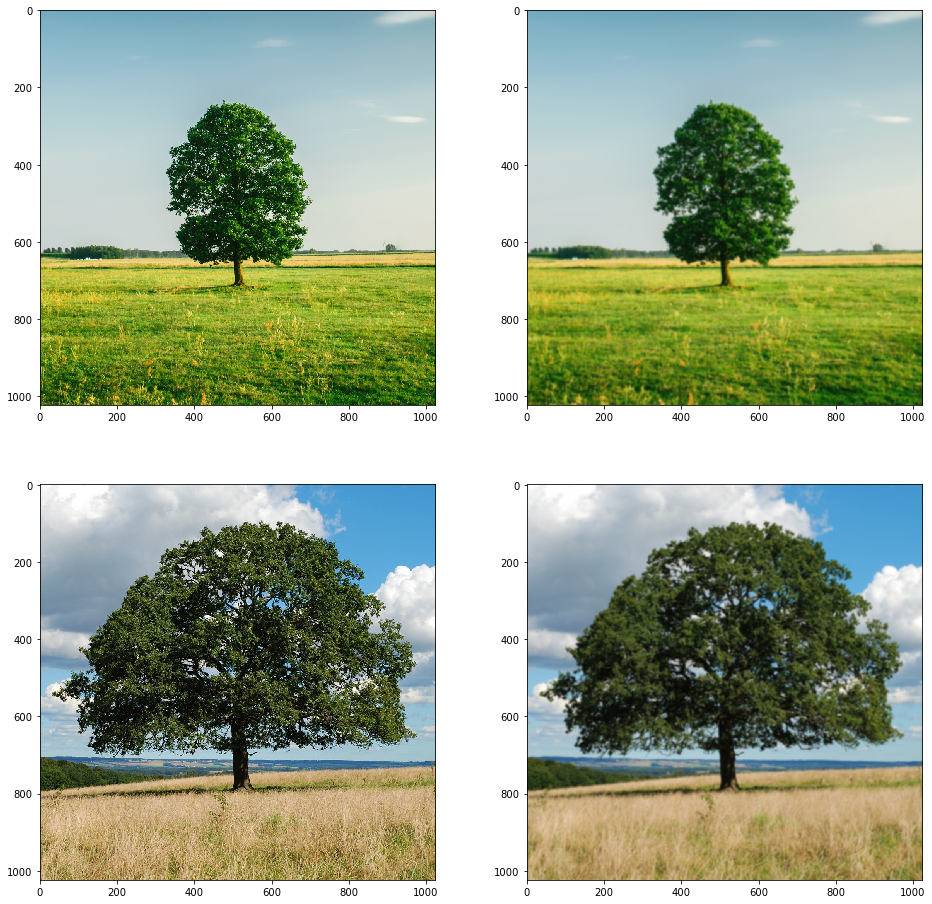

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
ax[0, 0].imshow(original_immage)
ax[0, 1].imshow(blured_image)
ax[1, 0].imshow(test_image)
ax[1, 1].imshow(blured_test_image)
plt.show()

### Строим и обучаем нейронную сеть

In [5]:
%%time
model = Sequential()
model.add(Dense(512, input_shape=(input_dim,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(output_dim, activation='sigmoid'))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [6]:
%%time
history = model.fit(train_x_net,
                    train_y_net,
                    validation_data=(test_x_net, test_y_net),
                    batch_size=32,
                    epochs=50, verbose=2)

model.save('model')

In [7]:
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.legend(['Train loss ({})'.format(history.history['loss'][-1]), \
           'Test loss ({})'.format(history.history['val_loss'][-1])])
ax.grid(ls=':')
plt.show()

In [8]:
model = models.load_model('model')

def deblur_image(image):
    recontructed_image = np.zeros((image.shape[0], image.shape[1], 3))
    for x in range(window_size // 2, image.shape[1] - window_size // 2 + 1, window_size):
        for y in range(window_size // 2, image.shape[0] - window_size // 2 + 1, window_size):
            region = image[y - window_size // 2:y + window_size // 2,
                           x - window_size // 2:x + window_size // 2].ravel()            
            result = model.predict(np.array([region]))
            result = np.squeeze(result)
            recontructed_image[y - window_size // 2:y + window_size // 2,
                               x - window_size // 2:x + window_size // 2] = result.reshape(window_size, window_size, 3)
            
    return recontructed_image

In [9]:
%%time
recontructed_image = deblur_image(blured_image)
reconstructed_test_image = deblur_image(blured_test_image)

Wall time: 41 s


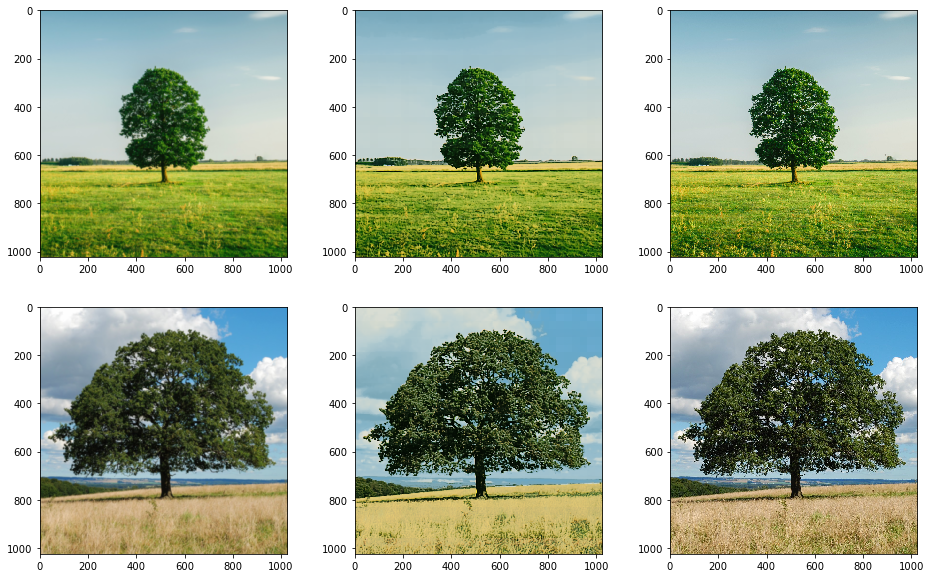

Wall time: 1.2 s


In [10]:
%%time
fig, ax = plt.subplots(2, 3, figsize=(16, 10))
ax[0, 0].imshow(blured_image)
ax[0, 1].imshow(recontructed_image)
ax[0, 2].imshow(original_immage)
ax[1, 0].imshow(blured_test_image)
ax[1, 1].imshow(reconstructed_test_image)
ax[1, 2].imshow(test_image)
plt.show()